# Старт

Max Private score
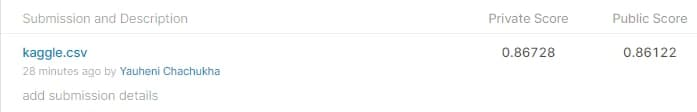
Same metric value in leaderboard. TOP 97 place
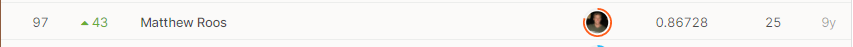

Max Public score
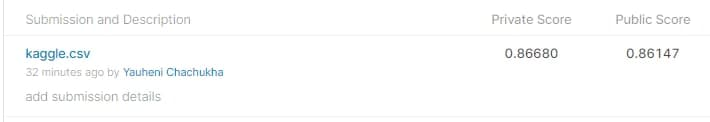
Same metric value in leaderboard. TOP 89 place
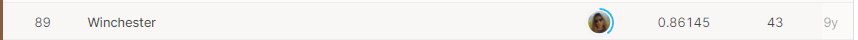

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn.metrics import roc_auc_score as ras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.ensemble import RandomForestClassifier as RFC

In [ ]:
df = pd.read_csv('/kaggle/input/GiveMeSomeCredit/cs-training.csv', index_col=0)
df["Index"] = [el for el in range(df.shape[0])]
df.set_index("Index", inplace=True)
df.head()

In [ ]:
df.info()

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True)

Change "MonthlyIncome" blowouts

In [ ]:
float(df["MonthlyIncome"].quantile([0.975]))

In [ ]:
a = [el * 5 for el in range(0, 25, 2)]
b = [el * 5 for el in range(2, 25, 2)]
for el_1, el_2 in zip(a, b):
    
    
    df["MonthlyIncome"] = np.where(
        (df["age"] > el_1)  & 
        (df["age"] <= el_2) & 
        (df[(df["age"] > el_1)  & 
            (df["age"] <= el_2)]["MonthlyIncome"] >= 
         float(df[(df["age"] > el_1)  & 
                  (df["age"] <= el_2)]["MonthlyIncome"].quantile([0.975]))), 
        df[(df["age"] > el_1)  & (df["age"] <= el_2)]["MonthlyIncome"].mean(), 
        df["MonthlyIncome"]
    )

Inputation of null values "MonthlyIncome" with help of age category and step = 10

In [ ]:
df["MonthlyIncome"] = np.where((df["age"] > 65)  & (df["MonthlyIncome"].isnull() == True), \
                               df[df["age"] > 65]["MonthlyIncome"].mean(), df["MonthlyIncome"])


df["MonthlyIncome"] = np.where((df["age"] <= 25) & (df["MonthlyIncome"].isnull() == True), \
                               df[(df["age"] <= 25)]["MonthlyIncome"].mean(), df["MonthlyIncome"])

In [ ]:
a = [el * 5 for el in range(5, 25, 2)]
b = [el * 5 for el in range(7, 25, 2)]
for el_1, el_2 in zip(a, b):
    
    df["MonthlyIncome"] = np.where(
        (df["age"] > el_1)  & 
        (df["age"] <= el_2) & 
        (df["MonthlyIncome"].isnull() == True), 
        df[(df["age"] > el_1)  & (df["age"] <= el_2)]["MonthlyIncome"].mean(), 
        df["MonthlyIncome"]
    )

Get class weights for disbalanced classes

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(np.ravel(df.iloc[:, 0:1])),
                                                 np.ravel(df.iloc[:, 0:1]))

class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

Inputation of null values of "NumberOfDepends". Make category "big family" with more than 5 chlidren or dependets

In [ ]:
df.groupby(["NumberOfDependents"]).count()

In [ ]:
df["NumberOfDependents"] = np.where(df["NumberOfDependents"].isnull() == True, \
                                         np.where(df["age"] <= 35, 0, 2), df["NumberOfDependents"])
df["NumberOfDependents"] = np.where(df["NumberOfDependents"] >= 5, 5, df["NumberOfDependents"])

Change "DebtRatio" with help of age and mean value of that group

In [ ]:
a = [el * 5 for el in range(5, 25, 2)]
b = [el * 5 for el in range(7, 25, 2)]
for el_1, el_2 in zip(a, b):
    
    df["DebtRatio"] = np.where(
        (df["age"] > el_1)  & 
        (df["age"] <= el_2) & 
        (df["MonthlyIncome"].isnull() == True), 
        df[(df["age"] > el_1)  & (df["age"] <= el_2)]["MonthlyIncome"].mean(), 
        df["MonthlyIncome"]
    )

Change "RevolvingUtilizationOfUnsecuredLines". The value of that feature should be between 0 and 1, so change bigger value with "2" as mark of "mistake".

In [ ]:
df[(df["RevolvingUtilizationOfUnsecuredLines"] > 1)]

In [ ]:
df["RevolvingUtilizationOfUnsecuredLines"] = np.where(
    df["RevolvingUtilizationOfUnsecuredLines"] > 1, 
    2, 
    df["RevolvingUtilizationOfUnsecuredLines"])

Dummi dependts

In [ ]:
df = pd.get_dummies(df, prefix_sep="", columns=["NumberOfDependents"], prefix="")

Split 

In [ ]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df.iloc[:, 1:], np.ravel(df.iloc[:, 0:1]), test_size = 0.25)

In [ ]:
X_train_5 = X_train_new
X_test_5 = X_test_new
y_train_5 = y_train_new
y_test_5 = y_test_new

Use Gridsearch for parametrization our model

In [ ]:
from sklearn.model_selection import StratifiedKFold as SF

In [ ]:
sf = SF(4, shuffle=True, random_state=15)

In [ ]:
split_data = sf.split(X_train_5, y_train_5)

In [ ]:
eraser = []
for el in split_data:
    eraser.append(el)

In [ ]:
split_data = sf.split(X_train_5, y_train_5)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {"n_estimators" : [1300, 1100, 100, 200],
             "max_features" : [2, 3, 4], 
             "min_samples_leaf" : [15, 13, 14, 1, 2, 5], 
             "min_samples_split" : [10, 11, 12], 
             "class_weight" : class_weights}

In [ ]:
rfc_2 = RFC()

In [ ]:
rfc_grid = GridSearchCV(estimator = rfc_2, 
                        param_grid = param_grid, 
                        scoring = 'roc_auc', 
                        cv = split_data, 
                        verbose = 2, 
                        n_jobs = -1)

In [ ]:
rfc_grid.fit(X_train_5, y_train_5)

In [ ]:
rfc_grid.cv_results_

Make same preprocessing for test data

In [ ]:
df_test = pd.read_csv('/kaggle/input/GiveMeSomeCredit/cs-test.csv', index_col=0)

In [ ]:
a = [el * 5 for el in range(0, 25, 2)]
b = [el * 5 for el in range(2, 25, 2)]
for el_1, el_2 in zip(a, b):
    
    
    df_test["MonthlyIncome"] = np.where(
        (df_test["age"] > el_1)  & 
        (df_test["age"] <= el_2) & 
        (df_test[(df_test["age"] > el_1) & 
                 (df_test["age"] <= el_2)]["MonthlyIncome"] >= 
         float(df_test[(df_test["age"] > el_1)  & 
                       (df_test["age"] <= el_2)]["MonthlyIncome"].quantile([0.975]))), 
        df_test[(df_test["age"] > el_1)  & 
                (df_test["age"] <= el_2)]["MonthlyIncome"].mean(), 
        df_test["MonthlyIncome"])

In [ ]:
df_test["MonthlyIncome"] = np.where((df_test["age"] > 65)  & (df_test["MonthlyIncome"].isnull() == True), \
                               df_test[df_test["age"] > 65]["MonthlyIncome"].mean(), df_test["MonthlyIncome"])


df_test["MonthlyIncome"] = np.where((df_test["age"] <= 25) & (df_test["MonthlyIncome"].isnull() == True), \
                               df_test[(df_test["age"] <= 25)]["MonthlyIncome"].mean(), df_test["MonthlyIncome"])

In [ ]:
a = [el * 5 for el in range(5, 25, 2)]
b = [el * 5 for el in range(7, 25, 2)]
for el_1, el_2 in zip(a, b):
    
    df_test["MonthlyIncome"] = np.where(
        (df_test["age"] > el_1)  & (df_test["age"] <= el_2) & (df_test["MonthlyIncome"].isnull() == True), 
        df_test[(df_test["age"] > el_1)  & (df_test["age"] <= el_2)]["MonthlyIncome"].mean(), 
        df_test["MonthlyIncome"]
    )

In [ ]:
df_test["NumberOfDependents"] = np.where(
    df_test["NumberOfDependents"].isnull() == True, 
    np.where(df_test["age"] <= 35, 0, 2), 
    df_test["NumberOfDependents"]
)

df_test["NumberOfDependents"] = np.where(
    df_test["NumberOfDependents"] >= 5, 
    5, 
    df_test["NumberOfDependents"]
)

In [ ]:
df_test["DebtRatio"] = np.where(
    (df_test["DebtRatio"] >= float(df["DebtRatio"].quantile([.975]))) == True, 
    df_test[df_test["DebtRatio"] < float(df["DebtRatio"].quantile([.975]))]["DebtRatio"].median(), 
    df_test["DebtRatio"]
)

In [ ]:
df_test["RevolvingUtilizationOfUnsecuredLines"] = np.where(
    df_test["RevolvingUtilizationOfUnsecuredLines"] > 1, 
    2, 
    df_test["RevolvingUtilizationOfUnsecuredLines"])

In [ ]:
df_test = pd.get_dummies(df_test, prefix_sep="", columns=["NumberOfDependents"], prefix="")

In [ ]:
X_test_main = df_test.iloc[:, 1:]

In [ ]:
id = [el + 1 for el in range(X_test_main.shape[0])]

Use grid params for random forest

In [ ]:
rfc_2.fit(X_train_5, y_train_5)

In [ ]:
print(ras(y_test_5, rfc_2.predict_proba(X_test_5)[:, 1]))

In [ ]:
pd.DataFrame({'Id': id,
              'Probability' : rfc_2.predict_proba(X_test_main)[:,1]}).to_csv("kaggle.csv", index = False)